# Класифікація залежностей з допомогою FNN
Візьмемо за основу парсер залежностей з 8 завдання, для якого:
на тестових реченнях UAS=0.78; 
на тестових реченнях, анотованих pymorphy2, UAS=0.6.
Використовуються вектори слів з лематизацією.

In [1]:
from conllu import parse
import logging
import pandas as pd
import numpy as np
from uddisplacy import ud_to_displacy
from metrics import *
from unlabeledparser import ArcEagerDependencyParser, MemoryFeatureExtractor
from pymorphy2tree import Pymorhy2Tree
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import SGD

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [139]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import log_loss, accuracy_score, classification_report
from keras.models import load_model
from keras.callbacks import EarlyStopping, ProgbarLogger, BaseLogger
import datetime
from matplotlib import pyplot
from unlabeledparser import get_root
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline

In [3]:
PATH = "data\\UD_Ukrainian-IU-master\\UD_Ukrainian-IU-master"
PATH_WV = 'C:\\work\\jul\\python_libs\\ubercorpus.cased.lemmatized.300d.bz2'

In [4]:
with open(PATH + "\\uk_iu-ud-train.conllu", "r", encoding='utf-8') as f:
    data = f.read()
train_trees = parse(data)
print(len(train_trees))

4513


In [5]:
with open(PATH + "\\uk_iu-ud-test.conllu", "r", encoding='utf-8') as f:
    data = f.read()
test_trees = parse(data)
print(len(test_trees))

783


In [6]:
dp = ArcEagerDependencyParser(feature_extractor = MemoryFeatureExtractor())
dp.load('vectorizer_20180516_2349.pql', 'classifier_20180516_2349.pql')
uas_parse(test_trees, dp.dep_parse, log=True); 

Total: 14939
Correctly defined: 11617
UAS: 0.78


In [7]:
df_test = pd.DataFrame()
for tree in test_trees:
    df_test = pd.concat([df_test, pd.DataFrame.from_dict(tree)])
df_test.groupby(['deprel']).count()

,id,form,lemma,upostag,xpostag,feats,head,deps,misc
deprel,,,,,,,,,
acl,176,176,176,176,176,174,176,0,176
advcl,135,135,135,135,135,132,135,0,135
advcl:sp,10,10,10,10,10,10,10,0,10
advcl:svc,4,4,4,4,4,4,4,0,4
advmod,644,644,644,644,644,395,644,0,644
amod,1459,1459,1459,1459,1459,1459,1459,0,1459
appos,105,105,105,105,105,104,105,0,105
aux,27,27,27,27,27,27,27,0,27
case,1373,1373,1373,1373,1373,1373,1373,0,1373


In [8]:
df_train = pd.DataFrame()
for tree in train_trees:
    df_train = pd.concat([df_train, pd.DataFrame.from_dict(tree)])
df_train.groupby(['deprel']).count()

,id,form,lemma,upostag,xpostag,feats,head,deps,misc
deprel,,,,,,,,,
acl,1003,1003,1003,1003,1003,974,1003,0,1003
advcl,1004,1004,1004,1004,1004,981,1004,0,1004
advcl:sp,52,52,52,52,52,52,52,0,52
advcl:svc,19,19,19,19,19,19,19,0,19
advmod,4158,4158,4158,4158,4158,2580,4158,0,4158
amod,6040,6040,6040,6040,6040,6040,6040,0,6040
appos,431,431,431,431,431,428,431,0,431
aux,151,151,151,151,151,151,151,0,151
case,6868,6868,6868,6868,6868,6867,6868,0,6868


#### Об'єднаємо підкатегорії (xcomp:sp -> xcomp) для тестування

In [39]:
def get_joined_labels(trees):
    labels = []
    for tree in trees:
        for node in tree:
            labels.append(node["deprel"].split(':')[0])
    return labels

test_labels_joined = get_joined_labels(test_trees)
print(len(test_labels_joined))

print(np.unique(test_labels_joined))

14939
['acl' 'advcl' 'advmod' 'amod' 'appos' 'aux' 'case' 'cc' 'ccomp'
 'compound' 'conj' 'cop' 'csubj' 'dep' 'det' 'discourse' 'expl' 'fixed'
 'flat' 'goeswith' 'iobj' 'list' 'mark' 'nmod' 'nsubj' 'nummod' 'obj'
 'obl' 'orphan' 'parataxis' 'punct' 'root' 'vocative' 'xcomp']


## FNN різної будови на векторах розмірності 600

In [13]:
wvect = KeyedVectors.load_word2vec_format(PATH_WV)
unk = np.zeros(300)

def get_vector(word):
    '''Safe way to get word vectors'''
    return wvect[word] if word in wvect.vocab else unk

In [80]:
def convert_to_v(features):
    v_features = np.zeros((len(features), features[0].shape[0]))
    for i in range(len(features)):
        v_features[i] = features[i]
    return v_features

def get_features_deprel(trees):
    '''Combining 2 word vectors to get a feature vector of size 600'''
    features = []
    labels = []
    for tree in trees:
        for node in tree:
            head = node["head"]
            v_node = get_vector(node["lemma"])
            v_head = get_vector(tree[head - 1]["lemma"]) if head > 0 else unk
            v = np.concatenate([v_node, v_head])
            features.append(v)
            labels.append(node["deprel"])
    return convert_to_v(features), labels

In [81]:
features, labels = get_features_deprel([train_trees[0]])
print(features.shape, len(labels))
print(labels)

(14, 600) 14
['case', 'obl', 'amod', 'nmod', 'flat:title', 'root', 'amod', 'nsubj', 'punct', 'appos', 'nmod', 'cc', 'conj', 'punct']


In [82]:
train_features, train_labels = get_features_deprel(train_trees)
print(train_features.shape, len(train_labels))

(75098, 600) 75098


In [83]:
test_features, test_labels = get_features_deprel(test_trees)
print(test_features.shape, len(test_labels))

(14939, 600) 14939


In [84]:
labels_rel = np.unique(train_labels)
print(labels_rel.shape, labels_rel)

(49,) ['acl' 'advcl' 'advcl:sp' 'advcl:svc' 'advmod' 'amod' 'appos' 'aux' 'case'
 'cc' 'ccomp' 'compound' 'compound:svc' 'conj' 'conj:svc' 'cop' 'csubj'
 'det' 'det:numgov' 'det:nummod' 'discourse' 'dislocated' 'expl' 'fixed'
 'flat' 'flat:foreign' 'flat:name' 'flat:repeat' 'flat:title' 'goeswith'
 'iobj' 'list' 'mark' 'nmod' 'nsubj' 'nsubj:pass' 'nummod' 'nummod:gov'
 'obj' 'obl' 'orphan' 'parataxis' 'parataxis:discourse' 'punct'
 'reparandum' 'root' 'vocative' 'xcomp' 'xcomp:sp']


In [85]:
y_train = label_binarize(train_labels, classes=labels_rel)
print(y_train.shape)
y_test = label_binarize(test_labels, classes=labels_rel)
print(y_test.shape)

(75098, 49)
(14939, 49)


In [111]:
# if None, train a model
model_fname = 'clf_deprel_20180517_163950.h5'
# model_fname = None 

# construct a nn model
def make_model_fnn(input_dim=600):
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) 
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu', kernel_initializer='he_normal')) 
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu', kernel_initializer='he_normal')) 
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu', kernel_initializer='he_normal')) 
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu', kernel_initializer='he_normal')) 
    model.add(Dense(labels_rel.shape[0], activation='softmax'))
    return model

if model_fname:
    print('Loading saved model from {}'.format(model_fname))
    model = load_model(model_fname)
else:
    model = make_model_fnn()
print(model.summary())

Loading saved model from clf_deprel_20180517_163950.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              615424    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)      

In [87]:
# helper functions
# https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/
def plot_history(history, filename = None):
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    if filename:
        pyplot.savefig(filename, dpi=80)
    pyplot.show()
    
def datetime_stamp():
    now = datetime.datetime.now()
    return '{}{:02d}{:02d}_{:02d}{:02d}{:02d}'.format(now.year, now.month, now.day, now.hour, now.minute, now.second)

In [88]:
batch_size=128

In [ ]:
# train a model
def train_model(model, train_features, y_train, validation_split=0.2, epochs=50, patience = 5, save = True):
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])
    estimator = model.fit(train_features, y_train,
                          validation_split=validation_split,
                          epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping, ProgbarLogger()])    
    if save:
        modelfname = 'clf_deprel_{}.h5'.format(datetime_stamp())
        print(modelfname)
        model.save(modelfname)    
    return estimator

estimator = None
if not model_fname:
    estimator = train_model(model, train_features, y_train)
    print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
          (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))  


Training history


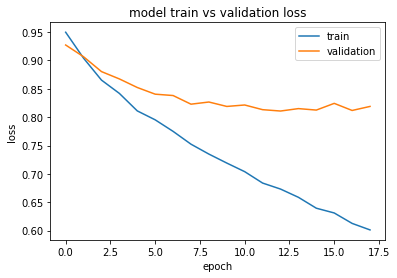

In [99]:
print('Training history')
if not model_fname:
    plot_history(estimator)
else:
    from IPython.display import Image
    display(Image("data\\3layer1024-05-1024-05-1024.png"))

In [100]:
# predicting deprel
score = model.evaluate(test_features, y_test, batch_size=batch_size)
print(score)

14939/14939 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 271us/step
[0.7716424089533329, 0.7816453578840961]


In [101]:
predicted = model.predict(test_features)

In [102]:
# scoring on original labels
loss_sk = log_loss(y_test, predicted)
print('Log loss is: {}'.format(loss_sk))

predicted_cat = np.empty_like(test_labels)
for i in range(predicted.shape[0]):
    predicted_cat[i] = labels_rel[np.argmax(predicted[i])]

acc_sk = accuracy_score(test_labels, predicted_cat)
print('Accuracy is: {}'.format(acc_sk))

print(classification_report(test_labels, predicted_cat))

Log loss is: 0.7785633041318232
Accuracy is: 0.7815784189035411


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

                acl       0.75      0.82      0.78       176
              advcl       0.50      0.01      0.01       135
           advcl:sp       1.00      0.10      0.18        10
          advcl:svc       0.00      0.00      0.00         4
             advmod       0.90      0.90      0.90       644
               amod       0.95      0.91      0.93      1459
              appos       0.00      0.00      0.00       105
                aux       0.72      0.67      0.69        27
               case       0.99      0.99      0.99      1373
                 cc       0.93      0.97      0.95       554
              ccomp       0.43      0.47      0.45        83
           compound       0.49      0.62      0.54        81
               conj       0.49      0.35      0.41       785
           conj:svc       0.00      0.00      0.00         2
                cop       0.87      0.96      0.91        80
              csubj    

In [103]:
# scoring on joined labels
predicted_joined_cat = np.empty_like(predicted_cat)
for i, x in enumerate(predicted_cat):
    predicted_joined_cat[i] = x.split(':')[0]
    
acc_sk = accuracy_score(test_labels_joined, predicted_joined_cat)
print('Accuracy on upper-level categories is: {}'.format(acc_sk))

print(classification_report(test_labels_joined, predicted_joined_cat))

Accuracy on upper-level categories is: 0.7849253631434501


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        acl       0.75      0.82      0.78       176
      advcl       0.67      0.01      0.03       149
     advmod       0.90      0.90      0.90       644
       amod       0.95      0.91      0.93      1459
      appos       0.00      0.00      0.00       105
        aux       0.72      0.67      0.69        27
       case       0.99      0.99      0.99      1373
         cc       0.93      0.97      0.95       554
      ccomp       0.43      0.47      0.45        83
   compound       0.49      0.62      0.54        81
       conj       0.49      0.35      0.41       787
        cop       0.87      0.96      0.91        80
      csubj       0.78      0.68      0.73        47
        dep       0.00      0.00      0.00         1
        det       0.96      0.96      0.96       446
  discourse       0.66      0.61      0.63       183
       expl       0.67      0.15      0.25        13
      fixed       0.89      0.26      0.40   

У таблиці показано результати експериментів з fnn на векторах розмірності 600. Додавання шарів однакової розмірності виявило проблему: після певної епохи крива validation loss починає підніматися вгору, validation accuracy падає. Цікавою виявилася архітектура мережі 2048-dropout(0.5)-1024-dropout(0.2)-512 або 1024-dropout(0.5)-1024-..., що не перенавчається настільки швидко. 

| model | epochs | training acc | validation acc | log loss on test | acc on test| description |
|---|---|---|---|---|---|---|
| clf_deprel_20180513_111643.h5 | 50 | 92.37% | 76.66% | 0.7881 | 77.87% | fnn with 1 relu layer of size 1000, sgd|
| clf_deprel_20180513_110532.h5 | 50 | 94.64% | 76.28% | 1.0567 | 77.73% | fnn with 2 relu layers of size 1000, sgd |
| clf_deprel_20180513_132722.h5 | 50 | 90.67% | 76.92% | 0.7917 | 77.84% | fnn with 1 relu layer of size 512, sgd |
| clf_deprel_20180513_134455.h5 | 50 | 95.22% | 75.75% | 1.1896 | 77.17% | fnn with 1 relu layer of size 1000, adam default,  decay=0 |
| clf_deprel_20180513_150303.h5 | 15 | 86.78% | 76.69% | 0.8047 | 77.96% | fnn with 3 relu layers of size 1024, dropout 0.2, sgd |
|clf_deprel_20180513_183037.h5 | 30 | 94.26% | 76.32% | 1.0361 | 77.86% | fnn 2048-0.2-1024-0.2-512, sgd |
|clf_deprel_20180513_193739.h5 | 30 | 92.32% | 76.46% | 1.3572 | 77.87% | fnn 2048-0.2-1024-0.2-512, sgd lr=0.005 |
| clf_deprel_20180513_200759.h5 | 30 | 89.82% | 77.28% | 0.8721 | 78.62% | fnn 2048-0.5-1024-0.2-512, sgd |
| clf_deprel_20180513_203429.h5 | 30 | 86.04% | 77.40% | 0.8088 | **78.70%** | fnn 1024-0.5-1024-0.5-1024, sgd |
| clf_deprel_20180513_212512.h5| 40| 86.65% | 77.44% | 0.9025 | 78.04% | fnn 5 layer 1024-0.5-..., sgd|
| clf_deprel_20180513_220815.h5 | 30 | 83.50% | 77.48% | 0.8070 | 78.40% | fnn 5 layer 1024-0.5-..., sgd|
| clf_deprel_20180517_163950.h5 | 17 | 81.24% | 77.45% | 0.7786 | **78.16%** | fnn 1024-0.5-1024-0.5-1024, sgd, small fix, stopped by early_stopping |

In [104]:
# make it all work together, get LAS on one sentence
class Parser():
    def __init__(self, dep_parse, model, get_features, labels):
        self.dep_parse = dep_parse
        self.model = model
        self.get_features = get_features
        self.labels = labels
        
    def parse_tree(self, golden_tree, parse_relations = True, classify_relations = True, normalize = True, copy_tree = True):
        #prepare and clean
        if copy_tree:
            tree = []
            for node in golden_tree:
                tree.append(node.copy())
        else:
            tree = golden_tree
        for node in tree:
            if parse_relations:
                node['head'] = None
            if classify_relations:
                node['deprel'] = None
        # get relations        
        if parse_relations:
            relations = self.dep_parse(tree)
            for i, head in relations:
                tree[i-1]['head'] = head
        if normalize:
            for node in tree:
                if not node['head']:
                    node['head'] = 0                
        # get relation labels   
        if classify_relations: 
            features, labels_ = self.get_features([tree])
            predicted = self.model.predict(features)
            deprel_cat = np.empty_like(labels_)
            for i in range(predicted.shape[0]):
                deprel_cat[i] = self.labels[np.argmax(predicted[i])]
            for i, x in enumerate(deprel_cat):
                tree[i]['deprel'] = x
        # normalize to remove None values
        if normalize:
            for node in tree:
                if not node['deprel']:
                    node['deprel'] = ''
        return tree

    
parser = Parser(dp.dep_parse, model, get_features_deprel, labels_rel)


print('-- Original tree --')
print_tree_deprel(train_trees[0])
print('-- Parsed tree: only classify relations --')
tree_copy = parser.parse_tree(train_trees[0], parse_relations = False, classify_relations = True) 
print_tree_deprel(tree_copy)
print('------------')
las_w([tree_copy], [train_trees[0]], log = True);
las_s([tree_copy], [train_trees[0]], log = True);
print('-- Parsed tree: full dependency relations parsing --')
tree_copy = parser.parse_tree(train_trees[0], parse_relations = True, classify_relations = True) 
print_tree_deprel(tree_copy)
print('------------')
las_w([tree_copy], [train_trees[0]], log = True);
las_s([tree_copy], [train_trees[0]], log = True);

-- Original tree --
У <-- домі (case)
домі <-- була (obl)
римського <-- патриція (amod)
патриція <-- домі (nmod)
Руфіна <-- патриція (flat:title)
була <-- root (root)
прегарна <-- фреска (amod)
фреска <-- була (nsubj)
, <-- зображення (punct)
зображення <-- фреска (appos)
Венери <-- зображення (nmod)
та <-- Адоніса (cc)
Адоніса <-- Венери (conj)
. <-- була (punct)
-- Parsed tree: only classify relations --
У <-- домі (case)
домі <-- була (obl)
римського <-- патриція (amod)
патриція <-- домі (nmod)
Руфіна <-- патриція (flat:title)
була <-- root (root)
прегарна <-- фреска (amod)
фреска <-- була (nsubj)
, <-- зображення (punct)
зображення <-- фреска (nmod)
Венери <-- зображення (nmod)
та <-- Адоніса (cc)
Адоніса <-- Венери (conj)
. <-- була (punct)
------------
Total: 14
Correctly defined: 13
LAS(word): 0.93
Total sentences: 1
LAS(sentence): 0.93
-- Parsed tree: full dependency relations parsing --
У <-- домі (case)
домі <-- була (obl)
римського <-- патриція (amod)
патриція <-- домі (nmod

In [105]:
def print_las(golden_trees, parser, parse_relations = True, classify_relations = True):
    trees = []
    for t in golden_trees:
        trees.append(parser.parse_tree(t, parse_relations=parse_relations, classify_relations=classify_relations))
    las_w(trees, golden_trees, log = True);
    las_s(trees, golden_trees, log = True);
    return
    

print('Scores for hand-annotated test trees:')
print('\nOnly classification:')
print_las(test_trees, parser, parse_relations=False)
print('\nRelation parsing and classification:')
print_las(test_trees, parser)

Scores for hand-annotated test trees:

Only classification:
Total: 14939
Correctly defined: 11676
LAS(word): 0.78
Total sentences: 783
LAS(sentence): 0.8

Relation parsing and classification:
Total: 14939
Correctly defined: 9534
LAS(word): 0.64
Total sentences: 783
LAS(sentence): 0.68


In [106]:
pm = Pymorhy2Tree()

def print_las_pymorphy(golden_trees, parser, parse_relations = True, classify_relations = True):
    trees = []
    for t in golden_trees:
        tt = pm.parse_tree_connlu(t)
        if not parse_relations:
            for i, node in enumerate(tt):
                node['head'] = t[i]['head']
        if not classify_relations:
            for i, node in enumerate(tt):
                node['deprel'] = t[i]['deprel']                
        trees.append(parser.parse_tree(tt, parse_relations=parse_relations, classify_relations=classify_relations))
    las_w(trees, golden_trees, log = True);
    las_s(trees, golden_trees, log = True);
    return
    

print('Scores for pymorphy2-annotated test trees:')
print('\nOnly classification:')
print_las_pymorphy(test_trees, parser, parse_relations=False)
print('\nRelation parsing and classification:')
print_las_pymorphy(test_trees, parser)

Scores for pymorphy2-annotated test trees:

Only classification:
Total: 14939
Correctly defined: 11149
LAS(word): 0.75
Total sentences: 783
LAS(sentence): 0.76

Relation parsing and classification:
Total: 14939
Correctly defined: 7204
LAS(word): 0.48
Total sentences: 783
LAS(sentence): 0.53


## Більше ознак для класифікації
Результати експериментів:

| description| input_dims| model | epochs | training acc | validation acc | log loss on test | acc on test | 
|---|---|---|---|---|---|---|---|
| fnn 1024-0.5-1024-0.5-1024 lemma vector, head lemma vector | 600 | clf_deprel_20180517_163950.h5 | 17 | 81.24% | 77.45% | 0.7786 | 78.16% | 
| lemma vector, head lemma vector, granddad lemma vector, distance | 901 | clf_deprel_20180517_172612.h5 | 22 | 86.28% | 79.81% | 0.7473 | 80.39% | 
| lemma vector, head lemma vector, granddad lemma vector, distance, ud features and 2-3-grams for word and head | 5470 | clf_deprel_20180517_190551.h5 | 12 | 96.33% | 93.30% | 0.3187 | 93.56% |

In [142]:
def get_ud_word_features(tree, node, prefix = ''):
    head = node["head"]
    features = {}
    features[prefix + 'pos'] = node['upostag']
    idx = node['id']-1
    q_left = tree[idx - 1] if idx > 0 else None
    q_right = tree[idx + 1] if idx + 1 < len(tree) else None
    features[prefix + '3gram'] = "{}_{}_{}".format(q_left['upostag'] if q_left else '', node['upostag'],
                                           q_right['upostag'] if q_right else '')
    features[prefix + '2gram-left'] = "{}_{}".format(q_left['upostag'] if q_left else '', node['upostag'])
    features[prefix + '2gram-right'] = "{}_{}".format(node['upostag'], q_right['upostag'] if q_right else '')  
    if node["feats"]:
        for k, v in node["feats"].items():
            features[prefix + 'f-' + k] = v
    return features

def get_ud_features(tree, node):
    features = {}
    features.update(get_ud_word_features(tree, node))
    if node['head'] > 0:
        features.update(get_ud_word_features(tree, tree[node['head']-1], 'h-'))   
    return features
            
def fit_vectorizer(trees, get_features=get_ud_features):
    features = []
    for tree in trees:
        for node in tree:
            features.append(get_features(tree, node))
    vectorizer = DictVectorizer()
    vectorizer.fit(features)
    return vectorizer

ud_feature_vectorizer = fit_vectorizer(train_trees+test_trees, get_ud_features)

print(get_ud_features(train_trees[0], train_trees[0][0]))
print(get_ud_features(train_trees[0], train_trees[0][1]))
if ud_feature_vectorizer:
    print(len(ud_feature_vectorizer.get_feature_names()))
else:
    print('Vectorizer is not trained')

{'pos': 'ADP', '3gram': '_ADP_NOUN', '2gram-left': '_ADP', '2gram-right': 'ADP_NOUN', 'f-Case': 'Loc', 'h-pos': 'NOUN', 'h-3gram': 'ADP_NOUN_ADJ', 'h-2gram-left': 'ADP_NOUN', 'h-2gram-right': 'NOUN_ADJ', 'h-f-Animacy': 'Inan', 'h-f-Case': 'Loc', 'h-f-Gender': 'Masc', 'h-f-Number': 'Sing'}
{'pos': 'NOUN', '3gram': 'ADP_NOUN_ADJ', '2gram-left': 'ADP_NOUN', '2gram-right': 'NOUN_ADJ', 'f-Animacy': 'Inan', 'f-Case': 'Loc', 'f-Gender': 'Masc', 'f-Number': 'Sing', 'h-pos': 'VERB', 'h-3gram': 'PROPN_VERB_ADJ', 'h-2gram-left': 'PROPN_VERB', 'h-2gram-right': 'VERB_ADJ', 'h-f-Aspect': 'Imp', 'h-f-Gender': 'Fem', 'h-f-Mood': 'Ind', 'h-f-Number': 'Sing', 'h-f-Tense': 'Past', 'h-f-VerbForm': 'Fin'}
4569


In [174]:
def get_features_ex(trees):
    '''Combining 2 word vectors to get a feature vector of size 600'''
    #options
    option_granddad = True
    option_distance = True
    option_feature_extractor = True and ud_feature_vectorizer != None
    
    root = get_root()
    
    features = []
    labels = []
    for tree in trees:
        for node in tree:
            head = node["head"]
            head_node = tree[head - 1] if head > 0 else root
            v_node = get_vector(node["lemma"])
            v_head = get_vector(tree[head - 1]["lemma"]) if head > 0 else unk
            # base node, head vector
            v = np.concatenate([v_node, v_head])
            if option_granddad:
                head_head = tree[head - 1]['head'] if head > 0 else 0
                v_granddad = get_vector(tree[head_head - 1]["lemma"]) if head > 0 else unk
                v = np.concatenate([v, v_granddad])
            if option_distance:
                max_distance = 7
                d = (head_node['id'] - node['id'])/max_distance
                d = d if d < 1 else 1
                d = d if d > -1 else -1 
                v_distance = np.array([d])
                v = np.concatenate([v, v_distance])
            if option_feature_extractor:
                udf = get_ud_features(tree, node)
                v_udf = ud_feature_vectorizer.transform(udf)
                v = np.concatenate([v, v_udf.toarray()[0]])
            features.append(v)
            labels.append(node["deprel"])
    return convert_to_v(features), labels

f, l = get_features_ex([train_trees[0]])
input_dim = f.shape[1]
print('Input vector dimensions:', input_dim)

Input vector dimensions: 5470


In [175]:
# if None, train a model
# model_fname = 'clf_deprel_20180517_163950.h5'
model_fname = None 

if model_fname:
    print('Loading saved model from {}'.format(model_fname))
    model = load_model(model_fname)
else:
    model = make_model_fnn(input_dim)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1024)              5602304   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              1049600   
__________

In [176]:
train_features, train_labels = get_features_ex(train_trees)
print(train_features.shape, len(train_labels))

(75098, 5470) 75098


In [177]:
test_features, test_labels = get_features_ex(test_trees)
print(test_features.shape, len(test_labels))

(14939, 5470) 14939


In [ ]:
estimator = None
if not model_fname:
    estimator = train_model(model, train_features, y_train)
    print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
          (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))  

Training history


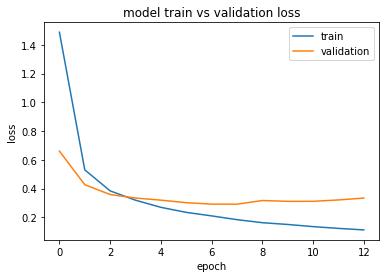

In [179]:
print('Training history')
if estimator:
    plot_history(estimator)

In [180]:
model.evaluate(test_features, y_test, batch_size=batch_size)

14939/14939 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 9s 602us/step


[0.3044123030170091, 0.9356717317288991]

In [181]:
predicted = model.predict(test_features)

In [182]:
# scoring on original labels
loss_sk = log_loss(y_test, predicted)
print('Log loss is: {}'.format(loss_sk))

predicted_cat = np.empty_like(test_labels)
for i in range(predicted.shape[0]):
    predicted_cat[i] = labels_rel[np.argmax(predicted[i])]

acc_sk = accuracy_score(test_labels, predicted_cat)
print('Accuracy is: {}'.format(acc_sk))

print(classification_report(test_labels, predicted_cat))

Log loss is: 0.3187012821794893
Accuracy is: 0.9356047928241515


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

                acl       0.87      0.90      0.89       176
              advcl       0.69      0.49      0.57       135
           advcl:sp       1.00      0.40      0.57        10
          advcl:svc       0.00      0.00      0.00         4
             advmod       0.96      0.99      0.98       644
               amod       0.99      1.00      0.99      1459
              appos       0.43      0.17      0.24       105
                aux       0.96      0.93      0.94        27
               case       0.99      1.00      1.00      1373
                 cc       0.99      0.99      0.99       554
              ccomp       0.52      0.76      0.61        83
           compound       0.83      0.60      0.70        81
               conj       0.77      0.76      0.77       785
           conj:svc       0.00      0.00      0.00         2
                cop       0.96      1.00      0.98        80
              csubj    

In [183]:
# scoring on joined labels
predicted_joined_cat = np.empty_like(predicted_cat)
for i, x in enumerate(predicted_cat):
    predicted_joined_cat[i] = x.split(':')[0]
    
acc_sk = accuracy_score(test_labels_joined, predicted_joined_cat)
print('Accuracy on upper-level categories is: {}'.format(acc_sk))

print(classification_report(test_labels_joined, predicted_joined_cat))

Accuracy on upper-level categories is: 0.9382154093312806


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        acl       0.87      0.90      0.89       176
      advcl       0.71      0.47      0.56       149
     advmod       0.96      0.99      0.98       644
       amod       0.99      1.00      0.99      1459
      appos       0.43      0.17      0.24       105
        aux       0.96      0.93      0.94        27
       case       0.99      1.00      1.00      1373
         cc       0.99      0.99      0.99       554
      ccomp       0.52      0.76      0.61        83
   compound       0.83      0.60      0.70        81
       conj       0.78      0.76      0.77       787
        cop       0.96      1.00      0.98        80
      csubj       0.90      0.74      0.81        47
        dep       0.00      0.00      0.00         1
        det       0.99      1.00      0.99       446
  discourse       0.92      0.95      0.93       183
       expl       0.79      0.85      0.81        13
      fixed       0.85      0.55      0.67   

In [186]:
parser = Parser(dp.dep_parse, model, get_features_ex, labels_rel)
print('Scores for hand-annotated test trees:')
print('\nOnly classification:')
print_las(test_trees, parser, parse_relations=False)
print('\nRelation parsing and classification:')
print_las(test_trees, parser)

Scores for hand-annotated test trees:

Only classification:
Total: 14939
Correctly defined: 13977
LAS(word): 0.94
Total sentences: 783
LAS(sentence): 0.94

Relation parsing and classification:
Total: 14939
Correctly defined: 11137
LAS(word): 0.75
Total sentences: 783
LAS(sentence): 0.79


In [187]:
print('Scores for pymorphy2-annotated test trees:')
print('\nOnly classification:')
print_las_pymorphy(test_trees, parser, parse_relations=False)
print('\nRelation parsing and classification:')
print_las_pymorphy(test_trees, parser)

Scores for pymorphy2-annotated test trees:

Only classification:
Total: 14939
Correctly defined: 11037
LAS(word): 0.74
Total sentences: 783
LAS(sentence): 0.76

Relation parsing and classification:
Total: 14939
Correctly defined: 7302
LAS(word): 0.49
Total sentences: 783
LAS(sentence): 0.54
